<img src="chess_pos.png">

<center><h1 style="font-size: 40px">Evaluating Chess Positions</h1>
<h4>By Kevin Peachey and Francisco Morales</h4></center>
<hr>

## Introduction

We love Chess, as do many other people. So for this tutorial, we are taking our own crack at a predictive chess model. We believe that we can extrapolate some interesting data from online chesss games, especially from the move list, and build our own chess engine. 

On Kaggle, we found a dataset of around 20k online chess matches. We are going to tidy this data, perform some exploratory analysis on the features of the matches, and create a model that predicts the chances of winning for a given board position. We will finally compare our model to another one using traditional weights on each of the pieces. 

### Imports

In [1]:
!pip install chess

     |████████████████████████████████| 140 kB 5.3 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import chess
import chess.svg
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

## Dataset

The dataset we'll be using is a .csv of ~20,000 games played on lichess.org, a free chess website. The fields of interest to us are the ratings of the players, which player won, and the moves, which will allow us to reconstruct the games and evaluate positions that come up. It's worth noting that there are no null values in the dataset, which will simplify the data-cleaning process.

In [54]:
df = pd.read_csv("games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## Data Cleaning

### Outlier games

Since this dataset is a collection of games that were played online, there may be games that ended for reasons outside of the game itself. For instance, a player may resign if they have an obligation in the real world to attend to, irrespective of the current board position. Games may also end if a player loses connection during the match. These games introduce noise into our analysis, since their outcomes may have nothing to do with the moves played.

While there is no way to detect all of these games, we can use domain knowledge to elimate some of them. For instance, sometimes a player will leave an online match before they play any moves because they started a new game accidentally. Since it is very rare for a chess game to end after few moves, games that have only a few moves are most likely outliers in which a player had to leave early.

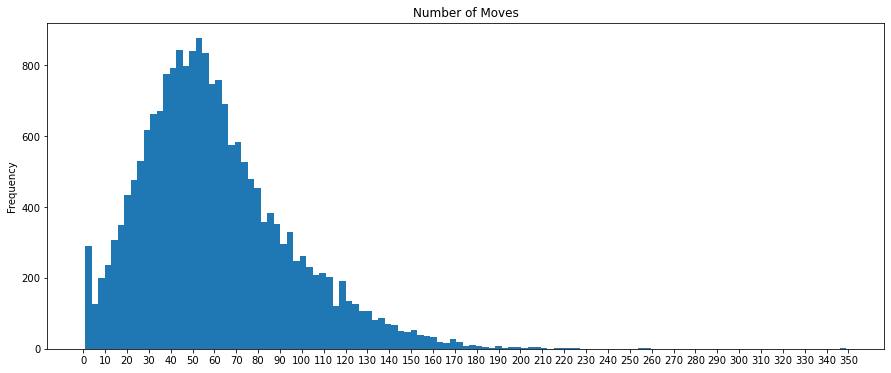

In [55]:
df['turns'].plot.hist(title='Number of Moves', bins=117, figsize=(15,6), xticks=range(0,351,10))

As shown by the histogram, there are around 300 games that have 0-3 moves, which represents a local maximum. This spike around 0 suggests that it is relatively common to start a new game accidentally, since there are many more games with 0-3 moves than in any of the bins from 3-12 moves. We will remove these 300 games from the dataset since it is almost certain that they ended due to external reasons.

In [56]:
df.drop(df[df['turns'] <= 3].index, inplace=True)

Here's what the turn data looks like after the omission.

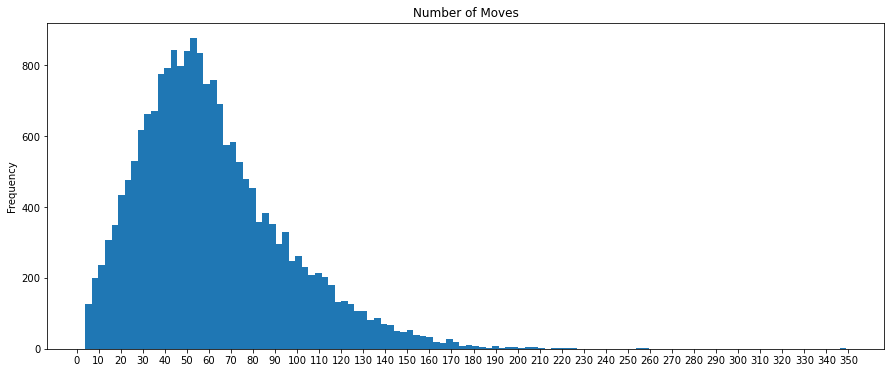

In [57]:
df['turns'].plot.hist(title='Number of Moves', bins=116, figsize=(15,6), xticks=range(0,351,10))

## Exploratory Data Analysis

We are going to explore some interesting correlations between opening moves and winning rate. Here, we are seeing if the material left in the first 10 moves can be a good predictor for winning.

In [7]:
df[['winner', 'turns', 'moves']].iloc[1][2]


'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+'

In [8]:
def num_materials(moves):
    # white and black
    takes = [0, 0]
    for (i, move) in enumerate(moves.split(" ")):
        # 0 = white, 1 = black
        color = i % 2
        
        # determine if this was a take
        take = 'x' in move
        
        # add take to tuple
        takes[color] += 1 if take else 0
    
    return (16 - takes[1], 16 - takes[0])

In [9]:
materials_left = num_materials(df[['winner', 'turns', 'moves']].iloc[1][2])
materials_left

(13, 14)

In [10]:
board = [[0 for i in range(1, 9)] for j in range(1,9)]
board
'''
.
3
2
1
  a  b  c  d...
  
a1 = board[7][0]
h8 = board[0][7]
'''

# Function to map position on board to index of 2D array
def pos_to_ind(pos):
    x = pos[0]
    y = pos[1]
    
    if x == 'a':
        x_ind = 7
    elif x == 'b':
        x_ind = 6
    elif x == 'c':
        x_ind = 5
    elif x == 'd':
        x_ind = 4
    elif x == 'e':
        x_ind = 3
    elif x == 'f':
        x_ind = 2
    elif x == 'g':
        x_ind = 1
    elif x == 'h':
        x_ind = 0
    
    return (x_ind, int(y) - 1)

print(pos_to_ind('h8'))

(0, 7)


### Material advantage

Material advantage is an intuitive measure of success in a chess match. Of course, material advantage isn't everything but it would be significant to compare the average material advantage (white vs black) with winning percentage. This will show us if having a higher material advantage over the course of the match is a good indicator of winning the match.

In [58]:
adv_df = df.copy()[['turns', 'winner', 'moves']]

In [59]:
# This function will calculate the avarage material advantage throughout the entire match 
def calc_adv(moves):
    # white and black
    takes = [16, 16]
    
    total_diff = 0 
    
    # Iterate through each turn
    for (i, move) in enumerate(moves.split(" ")):
        # 0 = white, 1 = black
        color = i % 2
        
        # Find if someone took in this turn
        did_take = 'x' in move
        if did_take:
            takes[(color + 1) % 2] -= 1
        
        # Add up differences
        total_diff += takes[0] - takes[1]
    
    # Average 
    return total_diff / len(moves)

Here, we calculate the average material advantage for each game. A negative value is an overall material advantage for black.

In [60]:
adv_df['avg_adv'] = [calc_adv(moves) for moves in adv_df['moves']]
adv_df.head(5)

,turns,winner,moves,avg_adv
0,13,white,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,0.200000
1,16,black,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,-0.015625
2,61,white,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,1.299213
3,61,white,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,0.293233
4,95,white,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,0.445570


This is the distribution of average material advantage in the dataset. As we can see, it seems to be symmetrically distributed around 0.

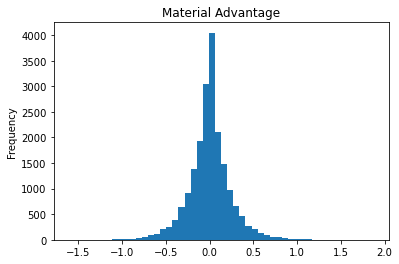

In [61]:
adv_df['avg_adv'].plot.hist(title='Material Advantage', bins=50)

Next, we can separate the continuous value of material advantage into 20 distinct bins. Then, those bins will be associated with the frequency of wins so we can determine what the correlation is between overall material advantage and win ratio.

In [15]:
adv_df['adv_bin'] = pd.qcut(adv_df['avg_adv'], 20, precision=2)
adv_df['win_ratio'] = adv_df['winner'].replace({'black':-1, 'draw':0, 'white':1})
adv_bin_win = adv_df[['adv_bin', 'win_ratio']].groupby('adv_bin', as_index=False).mean()

Finally, we plot 20 evenly spaced bins of the average advantage. We see a reassuring positive trend.

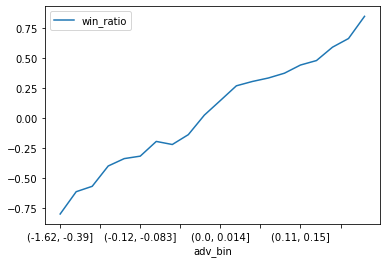

In [16]:
adv_bin_win.plot(x='adv_bin')

### Rating Differential

Another variable that we'll explore is the difference in rating between the two players. lichess.org uses the Glicko-2 rating system, which starts each player with a rating of 1500 and awards/removes points based on the outcomes of their matches. These rankings generally give a good indication of the skill of a player, so we'd expect that a player who has a higher ranking than their opponent is more likely to win by a margin roughly proportional to the difference in rank.

Here, we'll calculate the rating differential and get a sense of the distribution.

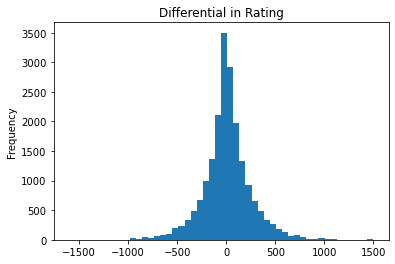

In [17]:
df['rating_diff'] = (df['white_rating']-df['black_rating'])
df['rating_diff'].plot.hist(title='Differential in Rating', bins=50)

It appears that differential in rating is symmetrically distributed and centered around zero, meaning that, on average, players should be evenly matched. To examine the effect of this differential on the outcome of the games, we will use qcut to split this Series into equally sized bins based on value, then plot the win rates of the bins against each other.

In [18]:
df['rating_bin'] = pd.qcut(df['rating_diff'], 5)

To compute average win rate, we'll need to convert the 'winner' column from a categorical variable into a number that can be averaged. We'll encode a victory for white as +1, victory for black as -1, and a draw as 0. With this encoding, a negative average would indicate that black has a higher winning rate for that bin, and vice versa for white.

In [19]:
df['win_ratio'] = df['winner'].replace({'black':-1, 'draw':0, 'white':1})

Finally, we'll group by the rating bin and compute the average win rate.

In [20]:
df_bin = df.groupby('rating_bin').mean()
df_bin

,rated,created_at,last_move_at,turns,white_rating,black_rating,opening_ply,rating_diff,win_ratio
rating_bin,,,,,,,,,
"(-1605.001, -146.0]",0.736922,1.481953e+12,1.481954e+12,59.142785,1442.118524,1765.393985,4.737427,-323.275461,-0.481173
"(-146.0, -29.0]",0.862601,1.485796e+12,1.485797e+12,64.087551,1548.759362,1627.842611,4.867915,-79.083249,-0.126265
"(-29.0, 39.0]",0.867503,1.487997e+12,1.487998e+12,64.025094,1589.107654,1584.605521,4.903388,4.502133,0.040151
"(39.0, 162.0]",0.845003,1.483758e+12,1.483759e+12,63.092846,1645.333841,1552.122527,4.877727,93.211314,0.226535
"(162.0, 1499.0]",0.719736,1.479823e+12,1.479824e+12,56.211597,1769.795015,1425.196846,4.916328,344.598169,0.562818


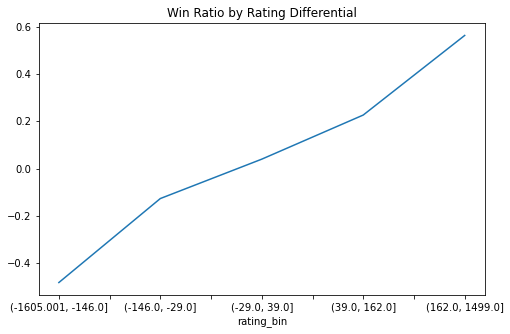

In [21]:
df_bin['win_ratio'].plot(title='Win Ratio by Rating Differential', figsize=(8,5))

As shown by the table and graph, there is a clear positive correlation between the win ratio and the rating differential between the two players. This trend makes a good deal of intuitive sense; if a player is higher rated than their opponent, they are more likely to win the match. The correlation suggests that the rating differential could be a useful variable to include in our evaluation model.

## ML/Testing

Now that we've determined that both rating and material difference predict win rate, we will use gradient descent to create a linear regression model based on these variables. This model will then be used to predict what the outcome of a game will be based on the current position. Explicitly, the model will be of the form:

\begin{equation*}
P = A(rating_W - rating_B) + B(pawns_W - pawns_B) + C(knights_W - knights_B) + D(bishops_W - bishops_B) + E(rooks_W - rooks_B) + F(queens_W - queens_B) + G
\end{equation*}

where P is the predicted win rate for the position and A-G are constants that will be optimized through gradient descent.

### Reformatting the Data

We'll use the first half of the data to train our model, and measure the accuracy of the predictions on the second half.

In [22]:
# Splitting the data approximately in half
df_training = df.iloc[:10000,:]
df_testing = df.iloc[10001:,:]

Right now, each row in the DataFrames represents one game. In order to train a function that evaluates a single position on the board, each of these games will need to be decomposed into the positions that occur at the end of each turn. Once this has been done, each row of the new dataframes will represent a single position, with fields for the rating difference, material advantages for each piece type, and outcome of the game. With this format, the rating difference and material difference columns represent all the variable inputs to the function, and the outcome column (value from -1 to 1) will be the target prediction values for the model.

In [23]:
def expand_game(row, out_arr):
    move_list = row['moves'].split()
    board = chess.Board()
    
    i = 0
    num_turns = len(move_list)

    while (i < num_turns):
        board.push(board.parse_san(move_list[i]))
        if (i < num_turns - 1):
            board.push(board.parse_san(move_list[i+1]))
        out_arr.append([row['id'],
                 row['rating_diff'],
                 len(board.pieces(chess.PAWN,chess.WHITE)) - len(board.pieces(chess.PAWN,chess.BLACK)),
                 len(board.pieces(chess.KNIGHT,chess.WHITE)) - len(board.pieces(chess.KNIGHT,chess.BLACK)),
                 len(board.pieces(chess.BISHOP,chess.WHITE)) - len(board.pieces(chess.BISHOP,chess.BLACK)),
                 len(board.pieces(chess.ROOK,chess.WHITE)) - len(board.pieces(chess.ROOK,chess.BLACK)),
                 len(board.pieces(chess.QUEEN,chess.WHITE)) - len(board.pieces(chess.QUEEN,chess.BLACK)),
                 row['win_ratio']
                ])
        i += 2

The expand_game function above takes a game (a row in the DataFrame) and outputs an array with information of interest for each turn in the game. This information is stored in the output array given as a parameter. Each turn in the game has a row in the array with the material information at that position, which is needed for the regression model. This function is applied to every row in the DataFrame, and the resultant array is used to create a new DataFrame in the format that we need.

In [24]:
cols = ['id', 'rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv','win_code']

# The expansion function is applied to each half of the data
move_info = []
df_training.apply(lambda row: expand_game(row, move_info), axis=1)
df_training_pos = pd.DataFrame(move_info, columns=cols)

move_info = []
df_testing.apply(lambda row: expand_game(row, move_info), axis=1)
df_testing_pos = pd.DataFrame(move_info, columns=cols)

In [25]:
df_training_pos.head(10)

,id,rating_diff,pawn_adv,knight_adv,bishop_adv,rook_adv,queen_adv,win_code
0,TZJHLljE,309,0,0,0,0,0,1
1,TZJHLljE,309,0,0,0,0,0,1
2,TZJHLljE,309,1,0,0,0,0,1
3,TZJHLljE,309,1,0,0,0,0,1
4,TZJHLljE,309,1,0,0,0,0,1
5,TZJHLljE,309,1,0,0,0,0,1
6,TZJHLljE,309,1,0,0,0,0,1
7,l1NXvwaE,61,0,0,0,0,0,-1
8,l1NXvwaE,61,0,0,0,0,0,-1
9,l1NXvwaE,61,0,0,0,0,0,-1


Every position reached in the games is encoded as a row in these new DataFrames, with the material advantage for the pieces at each position. The model 

### Fitting the Model

In the new format, the data can be used to fit the model using the formula from the beginning of the section. The package we're using to compute the regression model is statsmodels.formula.api, which allows the formula to be input as a string of DataFrame attributes. The resultant model is described below.

In [26]:
model = smf.ols('win_code ~ rating_diff + pawn_adv + knight_adv + bishop_adv + rook_adv + queen_adv', df_training_pos).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               win_code   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                 1.404e+04
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:15:52   Log-Likelihood:            -3.7929e+05
No. Observations:              300320   AIC:                         7.586e+05
Df Residuals:                  300313   BIC:                         7.587e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0349      0.002     22.255      

### Testing the Model

In [27]:
test_X = df_testing_pos[['rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv']]
pred_wins = model.predict(test_X)
pred_wins

0        -0.283844
1        -0.283844
2        -0.283844
3        -0.396248
4        -0.396248
            ...   
310864   -0.269754
310865   -0.269754
310866   -0.269754
310867   -0.269754
310868   -0.269754
Length: 310869, dtype: float64

In [28]:
df_testing_pos['win_code']

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
310864   -1
310865   -1
310866   -1
310867   -1
310868   -1
Name: win_code, Length: 310869, dtype: int64

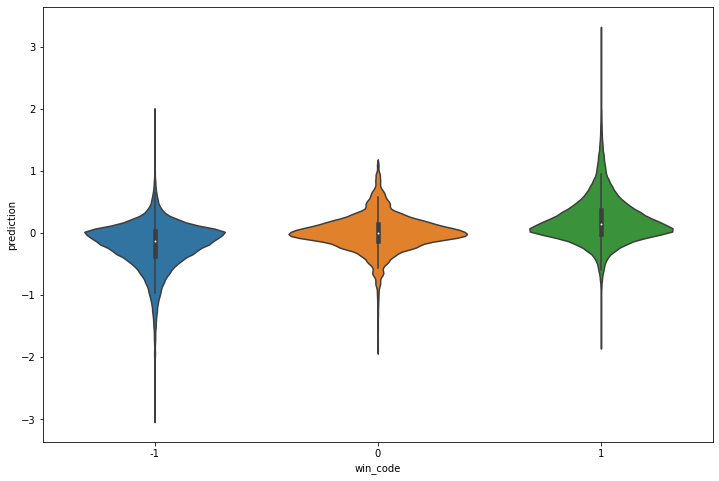

In [29]:
#plt.violinplot((df_testing_pos['win_code'], ), positions=[-1,0,1])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel("prediction")
sns.violinplot(x=df_testing_pos['win_code'], y=pred_wins)

In [30]:
def max_advantage(w):
    return 8*w[0] + 2*w[1] + 2*w[2] + 2*w[3] + w[4]

traditional_values = np.array([1,3,3,5,9])
a = max_advantage(traditional_values)

In [31]:
our_values = model.params[2:7]

b = max_advantage(our_values)

In [32]:
adj_trad_val = traditional_values / a * b

In [33]:
def pred_with_piece_weights(X, piece_weights, model):
    model_scale = max_advantage(model.params[2:7])
    custom_scale = max_advantage(piece_weights)
    
    adj = piece_weights * model_scale / custom_scale
    
    pred_y = model.params[0] + model.params[1]*X['rating_diff'] + adj[0]*X['pawn_adv'] + adj[1]*X['knight_adv'] \
                + adj[2]*X['bishop_adv'] + adj[3]*X['rook_adv'] + adj[4]*X['queen_adv']
    
    return pred_y

In [34]:
trad_pred_wins = pred_with_piece_weights(df_testing_pos, traditional_values, model)

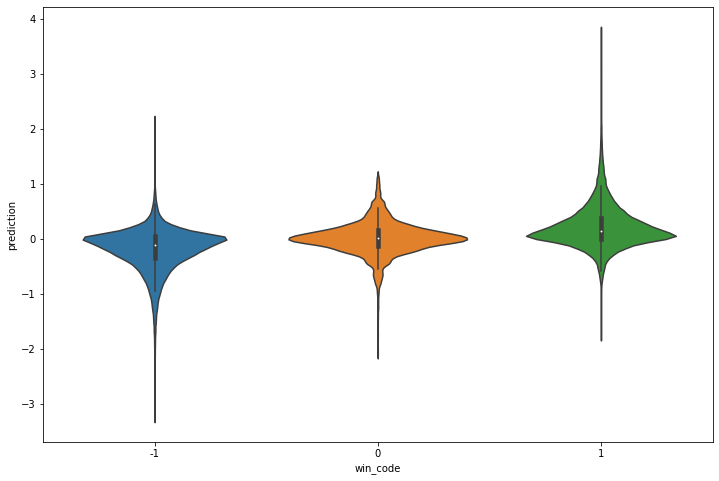

In [35]:
#plt.violinplot((df_testing_pos['win_code'], ), positions=[-1,0,1])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.ylabel("prediction")
sns.violinplot(x=df_testing_pos['win_code'], y=trad_pred_wins)

In [36]:
sklearn.metrics.mean_squared_error(df_testing_pos['win_code'], pred_wins)

0.7299180825851445

In [37]:
sklearn.metrics.mean_squared_error(df_testing_pos['win_code'], trad_pred_wins)

0.733261667920089

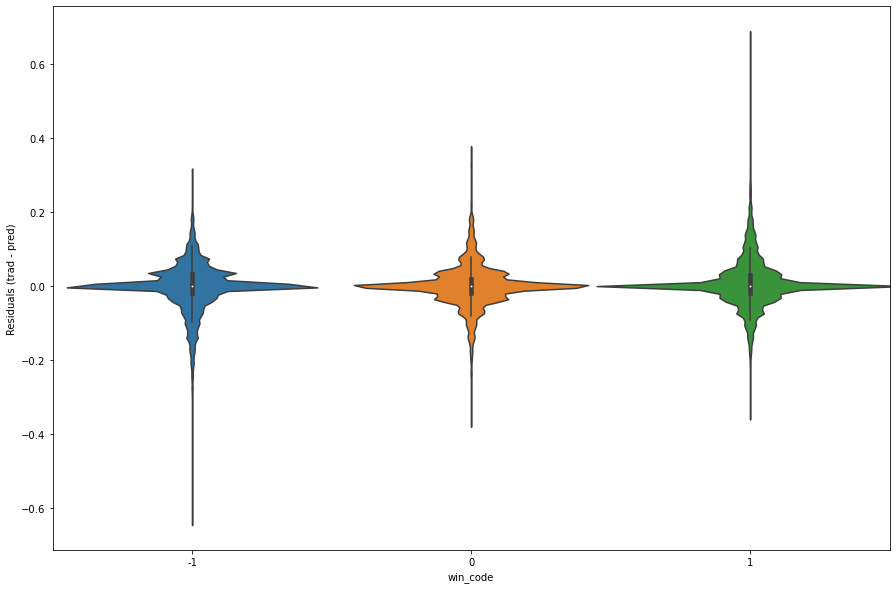

In [47]:
# find residuals
resid = trad_pred_wins - pred_wins

# plot residuals
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.ylabel("Residuals (trad - pred)")
sns.violinplot(x=df_testing_pos['win_code'], y=resid, width=1.1)

## Application: Basic Chess Engine

Now that we have a model that predicts the win rate based on a position, we can use this model to play chess by evaluating positions in real time. The 'evaluate' function below takes in a single board object and uses our model to determine the probability, P, that either player will win, which is a number between -1 and 1. The more positive P is, the greater the advantage for white; the more negative P is, the greater the advantage for black. If either player has won the game, the value of P will be +/-1, indicating an absolute advantage. If P is 0, both players are equally likely to win, or the position is a draw.

In [38]:
def evaluate(board, model):
    # If this position represents the end of the game, the model is not used since the outcome is known
    if (board.is_game_over()):
        result = board.result()
        # White wins
        if (result == '1-0'):
            return 1
        # Draw
        elif (result == '1/2-1/2'):
            return 0
        # Black wins
        elif (result == '0-1'):
            return -1
    
    # Otherwise, the position is evaluated using the model
    # Inputs position info into the a dataframe that is input as X into the regression model
    # Assumes that the player and computer are equally rated, so first value is 0
    position = pd.DataFrame([[0,
                 len(board.pieces(chess.PAWN,chess.WHITE)) - len(board.pieces(chess.PAWN,chess.BLACK)),
                 len(board.pieces(chess.KNIGHT,chess.WHITE)) - len(board.pieces(chess.KNIGHT,chess.BLACK)),
                 len(board.pieces(chess.BISHOP,chess.WHITE)) - len(board.pieces(chess.BISHOP,chess.BLACK)),
                 len(board.pieces(chess.ROOK,chess.WHITE)) - len(board.pieces(chess.ROOK,chess.BLACK)),
                 len(board.pieces(chess.QUEEN,chess.WHITE)) - len(board.pieces(chess.QUEEN,chess.BLACK))
                ]], columns=['rating_diff','pawn_adv','knight_adv','bishop_adv','rook_adv','queen_adv'])
    
    # P is computed using the model
    P = model.predict(position).values[0]
    return P

To apply this evaluation function to a live game of chess, we'll use the minimax algorithm, a well known algorithm for zero-sum games. The algorithm takes an integer, depth, as a parameter. If the depth is 1, the algorithm will evaluate each of the player's available moves (in this case, using the model from the previous section) and select the one with the best outcome for the current player. This is akin to looking ahead one move. To look ahead more moves, the function can be called with a higher depth. For instance, calling minimax with a depth of 3 will recursively evaluate all variations for 3 moves into the future,  and make the moves with the best evaluation at each node, assuming optimal play for both players. This implementation uses alpha-beta pruning, which is an optimization that stops evaluating a position once the decision outcome is already known. For more information, see https://www.geeksforgeeks.org/minimax-algorithm-in-game-theory-set-4-alpha-beta-pruning/.

In [39]:
# This implementation returns a tuple of (move, value), with move being the optimal move and value being the evaluation
# of the position
def minimax(board, depth, alpha, beta, model):
    # Base case is reached when depth = 0, or no moves possible
    # Returns raw evaluation with no move in the tuple
    if (depth == 0 or board.is_game_over()):
        return (chess.Move.null(), evaluate(board,model))
    
    # If white to move, algorithm maximizes evaluation
    elif (board.turn == chess.WHITE):
        best = (chess.Move.null(), -1)
        
        for move in board.legal_moves:
            # Makes move, then evaluates
            board.push(move)
            value = minimax(board, depth-1, alpha, beta, model)[1]
            
            if (value > best[1]):
                best = (move, value)
                
            # After evaluation, undoes move
            board.pop()
                
            # alpha-beta pruning - stops loop if black can already guarantee a better outcome
            alpha = max(value, alpha)
            if (beta <= alpha):
                break   
    
    # If black to move, algorithm minimizes evaluation
    else:   
        best = (chess.Move.null(), 1)
        
        for move in board.legal_moves:
            # Makes move, then evaluates
            board.push(move)
            value = minimax(board, depth-1, alpha, beta, model)[1]
            
            if (value < best[1]):
                best = (move, value)
            
            # After evaluation, undoes move
            board.pop()
            
            # alpha-beta pruning - stops loop if white can already guarantee a better outcome
            beta = min(value, beta)
            if (beta <= alpha):
                break 
            
    return best

The play function starts a game of chess with the computer. The user inputs moves in standard algebraic notation (SAN), and the computer uses the regression model and the minimax algorithm to come up with a response. The python-chess library is used to store the moves in a board object, and to display the board after every move.

In [40]:
def play(model):
    board = chess.Board()
    print("--- NEW GAME ---")
    display(chess.svg.board(board, size=300))
    print("You play white. Enter moves in standard algebraic notation, or type 'r' to resign:")
    
    # This method checks for checkmate, stalemate, insufficient material, or draws by repetition
    while (not board.is_game_over()):
        player_move_san = input(">>> ")
        
        # This loop ensures that the player's move is valid
        move_verified = False
        while (not move_verified):
            # Resignation ends the game
            if (player_move_san == 'r'):
                print("Black wins")
                return
            
            try:
                player_move = board.parse_san(player_move_san)
                move_verified = True
                break;
            # If the move causes a ValueError, the player must re-enter a valid move
            except ValueError:
                print("Invalid move")
                player_move_san = input(">>> ")

        # Once player's move has been verified, push to the board and display
        board.push(player_move)
        display(chess.svg.board(board, size=300))
        
        print("Thinking...")
        
        # Here's where our model is used - the minimax function with depth=3 is used to decide the computer's move
        computer_move = minimax(board,3,-1,1,model)[0]
        board.push(computer_move)
        display(chess.svg.board(board, size=300))
        
    # Once game is over, the state of the board is evaluated
    result = board.result()
    if (result == '1-0'):
        print("White wins")
    elif (result == '1/2-1/2'):
        print("Draw")
    elif (result == '0-1'):
        print("Black wins")
    return

### Sample Game:

--- NEW GAME ---


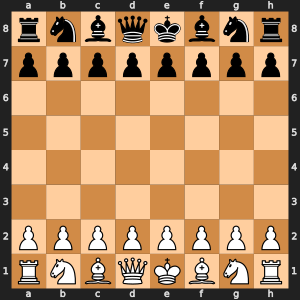

You play white. Enter moves in standard algebraic notation, or type 'r' to resign:


KeyboardInterrupt: Interrupted by user

In [41]:
play(model)

In [ ]:
# Computer playing itself
b = chess.Board()

while (not b.is_game_over()):
    move = minimax(b,3,-1,1,model)[0]
    b.push(move)
    display(chess.svg.board(b, size=300))